<a href="https://colab.research.google.com/github/dominiksakic/NETworkingMay/blob/main/13_separable_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depthwise separable convolution

- perform a spatial convolution on each channel of its inputs

- mixing output channels via a pointwise convolution

- Assumption:
  - spatial locations in intermediate activatoins are highly correlated, but different channels are highly independent.

- regular convolution operatoin with a 3 * 3 window, 64 input channels, and 64 output channels: 3*3*64*64 -> 36,864 trainable parameters

- sep convolution: 3*3*64 + 64 * 64 -> 4672 trainable parameters.

In [8]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle

Saving kaggle.json to kaggle.json


In [9]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

100% 809M/812M [00:07<00:00, 43.2MB/s]
100% 812M/812M [00:07<00:00, 114MB/s] 


In [10]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"
              for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
                      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [13]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

  residual = layers.Conv2D(size, 1,
                           strides=2, padding="same",
                           use_bias=False)(residual)

  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 180, 180,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 180, 180,  │          0 │ sequential_1[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 176, 176,  │      2,400 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_10 │ (None, 176, 176,  │      1,312 │ activation_10[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_11 │ (None, 176, 176,  │      1,312 │ activation_11[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 88, 88,    │      1,024 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 88, 88,    │          0 │ max_pooling2d_5[… │
│                     │ 32)               │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add_5[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_12 │ (None, 88, 88,    │      2,336 │ activation_12[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [14]:
model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [15]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="convnet_best_practices.keras",
    save_best_only=True,
    monitor="val_loss")
]


history = model.fit(
  train_dataset,
  epochs=100,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.5310 - loss: 0.7885 - val_accuracy: 0.5000 - val_loss: 0.6985
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.5610 - loss: 0.6754 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - accuracy: 0.6149 - loss: 0.6547 - val_accuracy: 0.5000 - val_loss: 0.6986
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.6453 - loss: 0.6403 - val_accuracy: 0.5000 - val_loss: 0.7240
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.6571 - loss: 0.6249 - val_accuracy: 0.5000 - val_loss: 0.7152
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.6634 - loss: 0.6139 - val_accuracy: 0.5000 - val_loss: 0.7970
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.6861 - loss: 0.6090 - val_accuracy: 0.5030 - val_loss: 0.8493
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.7032 - loss: 0.5738 - 

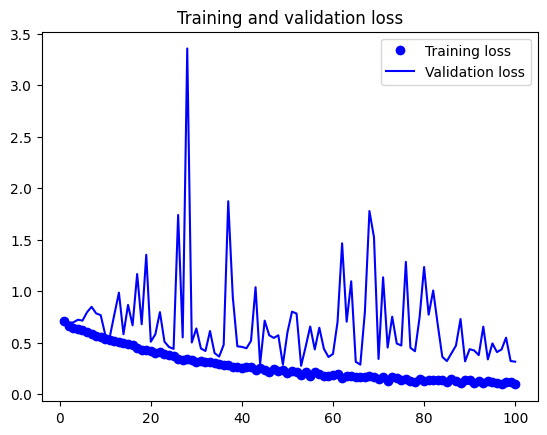

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

history = history.history
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

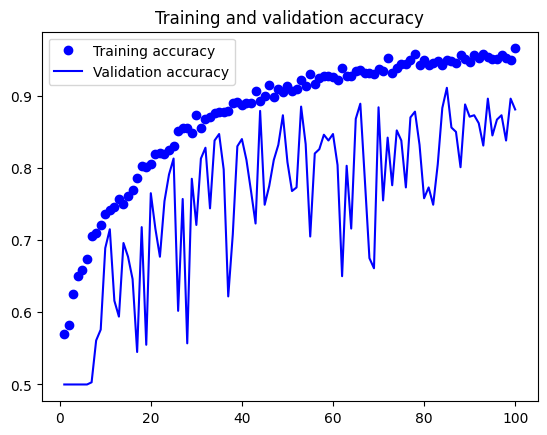

In [17]:
acc = history['accuracy']
val_acc = history['val_accuracy']
plt.plot(epochs, acc, 'bo', label= 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

In [18]:
test_model = keras.models.load_model("convnet_best_practices.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8715 - loss: 0.3250
Test accuracy: 0.878


# Convnet architecture principles
- Organized repeated blocks of layers, made of multiple convolution layers and a max pooling layer.

- number of filters should increase as the size of the spatial feature maps decreases.

- deep and narrow is better than broad and shallow

- use reisdual connections around blocks of layers helps you train deeper networks.

- use batch normalization layers after your convolutional layers

- repalce Conv2D layers with SeparableConv2D layers, which are more parameter-efficient.